# Capstone Project ー The Battle of Neighborhoods

## -  A guide map for Tokyo Special Wards  -

This notebook will be mainly used for the capstone project from course Applied Data Science Capstone by IBM on Coursera  
Coursera: https://www.coursera.org/learn/applied-data-science-capstone

### (Note: maps can not be displayed on github, so external links of maps are provided instead.)

### Section 1 : Data retrieve and pre-processing

The main datasets that we are interested for Tokyo Special Wards are below:  
● Demographic & geographic data (e.g. number, area, population, main neighborhoods, geographic coordinates, etc.)  
● Sociological & economic statistics data (e.g. Graduates rate, average annual income, monthly rental price, etc.)  
● Most common / popular venues nearby neighborhoods  


#### 1.1 Demographic & geographic data

In [1]:
import requests
import json
import lxml
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from math import cos, sin, atan2, sqrt, pi ,radians, degrees

%matplotlib inline

In [2]:
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.1               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ------------------------------------------------------------
                       

In [33]:
df_xls = pd.read_excel('https://www.toukei.metro.tokyo.lg.jp/jsuikei/2020/js203a0000.xls', nrows=29, skiprows=21, usecols=[1,2,7,8], names=None)
df_list = df_xls.values.tolist()
df = pd.DataFrame(df_list)
df.columns = ['Kanji', 'Population(2020)', 'Area(km²)', 'Density(/km²)']
df.dropna(axis=0, how='all',inplace=True)

df1 = df
df1.drop(index=[0],inplace=True)
df1.reset_index(drop=True,inplace=True)
df1.head()

,Kanji,Population(2020),Area(km²),Density(/km²)
0,千代田区,66080.0,11.66,5667.0
1,中央区,168553.0,10.21,16509.0
2,港区,260535.0,20.37,12790.0
3,新宿区,349101.0,18.22,19160.0
4,文京区,236043.0,11.29,20907.0


In [34]:
tables = pd.read_html("https://en.wikipedia.org/wiki/Special_wards_of_Tokyo")
df2 = pd.DataFrame(tables[3])
df2 = df2[['No.','Name','Kanji','Major districts']]
df2.drop(index=[23],inplace=True)
df2.drop(columns='No.',inplace=True)
df2.rename(columns={'Major districts':'Major_districts'}, inplace=True)
df_data = df2.merge(df1,how='outer')
df_data.head()

,Name,Kanji,Major_districts,Population(2020),Area(km²),Density(/km²)
0,Chiyoda,千代田区,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,...",66080.0,11.66,5667.0
1,Chūō,中央区,"Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb...",168553.0,10.21,16509.0
2,Minato,港区,"Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong...",260535.0,20.37,12790.0
3,Shinjuku,新宿区,"Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich...",349101.0,18.22,19160.0
4,Bunkyō,文京区,"Hongō, Yayoi, Hakusan",236043.0,11.29,20907.0


In [35]:
latitudes = []
longitudes = []
for address in df_data.Kanji:
    gps = Nominatim(user_agent="tky-explorer", timeout=50)
    location = gps.geocode(address)
    latitudes.append(location.latitude)
    longitudes.append(location.longitude)

In [36]:
df_data['MD_Latitude'] = latitudes
df_data['MD_Longitude'] = longitudes
df_data.head()

,Name,Kanji,Major_districts,Population(2020),Area(km²),Density(/km²),MD_Latitude,MD_Longitude
0,Chiyoda,千代田区,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,...",66080.0,11.66,5667.0,35.693810,139.753216
1,Chūō,中央区,"Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb...",168553.0,10.21,16509.0,35.666255,139.775565
2,Minato,港区,"Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong...",260535.0,20.37,12790.0,35.643227,139.740055
3,Shinjuku,新宿区,"Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich...",349101.0,18.22,19160.0,35.693763,139.703632
4,Bunkyō,文京区,"Hongō, Yayoi, Hakusan",236043.0,11.29,20907.0,35.718810,139.744732


#### 1.2 Sociological & economic statistics data

In [37]:
tables2 = pd.read_html("https://www.daiwahouse.co.jp/chintai/tokyo/souba/")
df3 = pd.DataFrame(tables2[0])
df3 = df3[['２３区','平均家賃（相場）']]
df3.rename(columns={'２３区':'Kanji', '平均家賃（相場）':'RMP/(MM_yen)'}, inplace=True)
df3['RMP/(MM_yen)'] = df3['RMP/(MM_yen)'].str.strip('万円')
df3.head()

,Kanji,RMP/(MM_yen)
0,千代田区,22.2
1,中央区,13.9
2,港区,19.4
3,新宿区,14.5
4,文京区,12.9


In [38]:
tables3 = pd.read_html("http://wildhog.hatenablog.com/entry/2018/05/01/170000", encoding='utf-8')
df4 = pd.DataFrame(tables3[0])
df4.drop(columns='Unnamed: 0',inplace=True)
df4.rename(columns={'市区町村名':'Kanji', '総数':'Total', '卒業者':'Graduates', '大学・大学院':'Uni_Grad', '大卒以上比率':'Uni_ratio'}, inplace=True)
df4.head()

,Kanji,Total,Graduates,Uni_Grad,Uni_ratio
0,千代田区,41978,38922,14290,36.7%
1,杉並区,432766,396403,143649,36.2%
2,中央区,109813,104866,37566,35.8%
3,文京区,182238,163476,58188,35.6%
4,港区,179914,170019,53193,31.3%


In [39]:
tables4 = pd.read_html('https://www.nenshuu.net/prefecture/shotoku/shotoku_pre.php?prefecture=%E6%9D%B1%E4%BA%AC%E9%83%BD')
df5 = pd.DataFrame(tables4[1])
df5.drop(index=[23],inplace=True)
df5 = df5[df5['市区町村'].str.contains("区")]
df5.rename(columns={'市区町村':'Kanji', '順位':'Rank', '平均所得（年収）':'AvAn/(MM_yen)'}, inplace=True)
df5.reset_index(drop=True,inplace=True)
df5['AvAn/(MM_yen)'] = df5['AvAn/(MM_yen)'].map(lambda x: str(x)[0:4])
df5['AvAn/(MM_yen)'] = df5['AvAn/(MM_yen)'].str.strip('万')
df5.drop(columns='Rank',inplace=True)
df5.head()

,Kanji,AvAn/(MM_yen)
0,港区,1217
1,千代田区,1081
2,渋谷区,872
3,中央区,690
4,目黒区,637


In [40]:
df_try = df4.merge(df5,how='outer')
df_try = df_try.merge(df3,how='outer')
df_try.to_csv('stat.csv')
statis = pd.read_csv('stat.csv')
statis.drop(columns='Unnamed: 0',inplace=True)
statis.drop(columns='Total',inplace=True)
statis['Uni_ratio'] = statis['Uni_ratio'].str.strip('%')
statis[['Uni_ratio']] = statis[['Uni_ratio']].astype('float')/100
statis.head()

,Kanji,Graduates,Uni_Grad,Uni_ratio,AvAn/(MM_yen),RMP/(MM_yen)
0,千代田区,38922,14290,0.367,1081,22.2
1,杉並区,396403,143649,0.362,472,10.4
2,中央区,104866,37566,0.358,690,13.9
3,文京区,163476,58188,0.356,623,12.9
4,港区,170019,53193,0.313,1217,19.4


In [41]:
data_final = df_data.merge(statis, how='outer')
data_final

,Name,Kanji,Major_districts,Population(2020),Area(km²),Density(/km²),MD_Latitude,MD_Longitude,Graduates,Uni_Grad,Uni_ratio,AvAn/(MM_yen),RMP/(MM_yen)
0,Chiyoda,千代田区,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,...",66080.0,11.66,5667.0,35.693810,139.753216,38922,14290,0.367,1081,22.2
1,Chūō,中央区,"Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb...",168553.0,10.21,16509.0,35.666255,139.775565,104866,37566,0.358,690,13.9
2,Minato,港区,"Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong...",260535.0,20.37,12790.0,35.643227,139.740055,170019,53193,0.313,1217,19.4
3,Shinjuku,新宿区,"Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich...",349101.0,18.22,19160.0,35.693763,139.703632,269217,73170,0.272,549,14.5
4,Bunkyō,文京区,"Hongō, Yayoi, Hakusan",236043.0,11.29,20907.0,35.718810,139.744732,163476,58188,0.356,623,12.9
5,Taitō,台東区,"Ueno, Asakusa",209463.0,10.11,20718.0,35.717450,139.790859,148672,31825,0.214,433,11.0
6,Sumida,墨田区,"Kinshichō, Morishita, Ryōgoku",270218.0,13.77,19624.0,35.700429,139.805017,208377,41100,0.197,387,10.4
7,Kōtō,江東区,"Kiba, Ariake, Kameido, Tōyōchō, Monzennakachō,...",519652.0,40.16,12940.0,35.649154,139.812790,381062,97930,0.257,445,13.5
8,Shinagawa,品川区,"Shinagawa, Gotanda, Ōsaki, Hatanodai, Ōimachi,...",412861.0,22.84,18076.0,35.599252,139.738910,305736,81460,0.266,497,11.7
9,Meguro,目黒区,"Meguro, Nakameguro, Jiyugaoka, Komaba, Aobadai",287741.0,14.67,19614.0,35.621250,139.688014,222140,66791,0.301,637,14.6


### Section 2 : Data Analyses

Now, we can catch a glimpse of the social and economic conditions in the 23 wards of Tokyo and get a rough idea through the collected data. 
Here are several typical kind of analytical statistic problems, which are also most interesed, such as:  

● Income and expenses (referred to here as rent prices)  
● Education level and income level  
● Population density and rent prices  


#### 2.1 Population density vs. Rental price

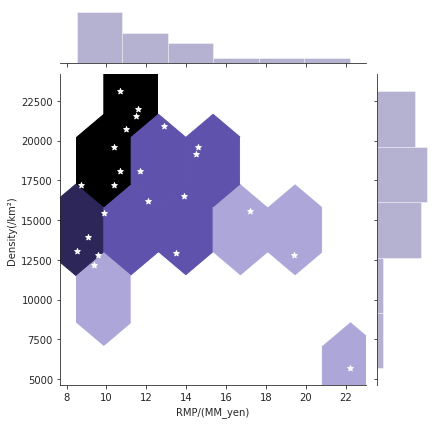

In [44]:
sns.set_style('ticks')
f = sns.jointplot(x="RMP/(MM_yen)", y="Density(/km²)", data=data_final, color='darkslateblue', height=6, kind="hex")
f.plot_joint(plt.scatter, c="w", s=35, linewidth=1, marker="*")

Generally speaking, there is no strong linear correlation between population density and monthly rent in Tokyo's 23 special wards. From the plot, the majority of the markers are concentrated in the upper left corner of the figure, indicating that districts with higher population density have mostly relative lower rental prices, which is in line with the market discipline. Areas with low population density, such as Chiyoda and Minato, have the highest rental prices on the contrary. Interestingly, Edogawa and Katsushika, which are with relative less population, also have the lower monthly rent.

#### 2.2 Graduation rate of university vs. Average annual income

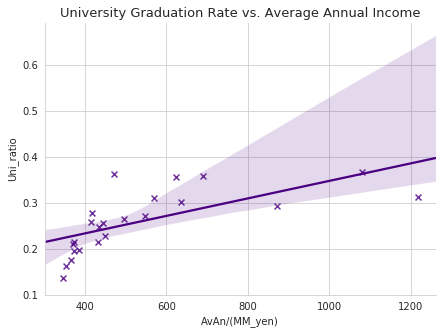

In [45]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
sns.regplot(x="AvAn/(MM_yen)", y="Uni_ratio", data=data_final, marker='x', color='indigo', scatter_kws={'s':35}, ax=ax)
plt.title('University Graduation Rate vs. Average Annual Income', fontsize=13)
sns.despine()

The top 3 players: Chiyoda, Minato and Shibuya in terms of average annual income ranking, are not very prominent in university graduation rate compared to other districts, and even slightly lower than some other districts. It can be seen that the overall university graduation rate in the Tokyo Special Wards area is basically similar in each district, and considering the mobility of workplace and residence to a certain extent, there is no strong linear correlation between the university graduation rate and average annual income.

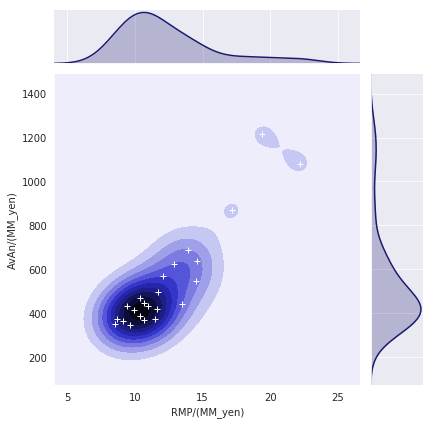

In [46]:
sns.set_style('darkgrid')
g = sns.jointplot(x="RMP/(MM_yen)", y="AvAn/(MM_yen)", data=data_final, kind="kde", height=6, color='midnightblue');
g.plot_joint(plt.scatter, c="w", s=35, linewidth=1, marker="+")

It can be seen that the curves of annual income and monthly rent price in Tokyo's 23 special wards have roughly the same trends, that is to say, the ratio of income and price is positively correlated in most districts. Moreover, the income and price ratio in most districts are relatively similar. It is not difficult to see from the above figure that most of Tokyo's 23 special wards have an average annual income of around 4 million yen, while the monthly rent is mainly around 100,000 yen (the marker cluster in darkest area). Calculated in this way, the annual rent expenditure is about 1.2 million yen, accounting for almost one-third of the entire income.This is not a good signal. Although it is far from enough to draw a convictive conclusion only from observing the rent prices perspective, but it still strongly shows that prices in Tokyo are way too expensive, and the ratio of income and expenditure is obviously unbalanced.  
Finally, as always, the best 3 outstanding players are still Chiyoda, Minato and Shibuya.

### Section 3 : Foursquare & Venues

When you decide to go on an in-depth tour in Tokyo, the general guidebook selling in the bookstore maybe not satisfy such kind of demand. Therefore, if we want to get more detailed tips for travelling or even living in Tokyo, we can use Foursquare to search the main local venues. The information package we get is very comprehensive, not only the gastronomic industry, but also including various tourist attractions, sightseeing spots, shopping areas, parks and whatever you want to know about.


#### 3.1 Visulization of Tokyo special wards map

In [47]:
url = 'https://raw.githubusercontent.com/utisz/compound-cities/master/tokyo.geo.json'
tokyo_shape = requests.get(url).json()

def shape_style(feature):
    return { 'color': 'purple' , 'fill': False }

In [48]:
add = 'Tokyo, Japan'
geolocator = Nominatim(user_agent="tky_explorer")
location = geolocator.geocode(add, timeout=50)
lat = location.latitude
lon = location.longitude

map_to = folium.Map(location=[lat, lon], zoom_start=11)

for lat, lng, district in zip(df_data['MD_Latitude'], df_data['MD_Longitude'], df_data['Major_districts']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map_to)  
    
folium.TileLayer('cartodbpositron').add_to(map_to)
folium.GeoJson(tokyo_shape, style_function=shape_style, name='geojson').add_to(map_to)


# Display the map
map_to

##### Link of map : https://drive.google.com/open?id=15plBs3FMVwKgJWnBhoJA6scPY3ZjPs08

#### 3.2 Get venue information nearby neighborhoods in Tokyo special wards

In [49]:
CLIENT_ID = 'HQ3EX0FYET5R5BGMGGTPFFIC53O4X1CYDNRHLZZZNPU4QCNO' # your Foursquare ID
CLIENT_SECRET = '1ETOP45JAC4NBPXP1YERNBP44WDB240UIBTC2XOHPGUE23TG' # your Foursquare Secret
VERSION = '20200511' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HQ3EX0FYET5R5BGMGGTPFFIC53O4X1CYDNRHLZZZNPU4QCNO
CLIENT_SECRET:1ETOP45JAC4NBPXP1YERNBP44WDB240UIBTC2XOHPGUE23TG


In [50]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Major_districts', 
                  'MD_Latitude', 
                  'MD_Longitude', 
                  'Venue', 
                  'VN_Latitude', 
                  'VN_Longitude', 
                  'Category']
    
    return(nearby_venues)

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [51]:
tokyo_venues = getNearbyVenues(names=df_data['Major_districts'],
                                   latitudes=df_data['MD_Latitude'],
                                   longitudes=df_data['MD_Longitude']
                                  )

Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi, Akihabara, Yūrakuchō, Iidabashi, Kanda
Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōbori, Shinkawa, Tsukishima, Kachidoki, Tsukuda
Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppongi, Toranomon, Aoyama, Azabu
Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ichigaya, Yotsuya
Hongō, Yayoi, Hakusan
Ueno, Asakusa
Kinshichō, Morishita, Ryōgoku
Kiba, Ariake, Kameido, Tōyōchō, Monzennakachō, Fukagawa, Kiyosumi, Shirakawa, Etchūjima, Sunamachi, Aomi
Shinagawa, Gotanda, Ōsaki, Hatanodai, Ōimachi, Tennōzu
Meguro, Nakameguro, Jiyugaoka, Komaba, Aobadai
Ōmori, Kamata, Haneda, Den-en-chōfu
Setagaya, Shimokitazawa, Kinuta, Karasuyama, Tamagawa
Shibuya, Ebisu, Harajuku, Daikanyama, Hiroo, Sendagaya, Yoyogi
Nakano
Kōenji, Asagaya, Ogikubo
Ikebukuro, Komagome, Senkawa, Sugamo
Akabane, Ōji, Tabata
Arakawa, Machiya, Nippori, Minamisenju
Itabashi, Takashimadaira
Nerima, Ōizumi, Hikarigaoka
Ayase, Kitasenju, Takenotsuka
Tateishi, Aoto, Kameari, Shibamata
Kasai, Koiwa


In [12]:
print(tokyo_venues.shape)
tokyo_venues.head()

(2300, 7)


,Major_districts,MD_Latitude,MD_Longitude,Venue,VN_Latitude,VN_Longitude,Category
0,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,...",35.69381,139.753216,Bondy (欧風カレー ボンディ),35.695544,139.757356,Japanese Curry Restaurant
1,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,...",35.69381,139.753216,Nippon Budokan (日本武道館),35.693356,139.749865,Stadium
2,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,...",35.69381,139.753216,National Museum of Modern Art (東京国立近代美術館),35.690541,139.754694,Art Museum
3,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,...",35.69381,139.753216,Kitanomaru Park (北の丸公園),35.691653,139.751201,Park
4,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,...",35.69381,139.753216,Kanda Coffee,35.697455,139.754686,Café


#### 3.3 Visulization of Tokyo venues map 

In [13]:
add = 'Tokyo, Japan'
geolocator = Nominatim(user_agent="tky_explorer")
location = geolocator.geocode(add, timeout=50)
lat = location.latitude
lon = location.longitude
print('The geograpical coordinate of Tokyo {}, {}.'.format(lat, lon))

The geograpical coordinate of Tokyo 35.6828387, 139.7594549.


Creat the heat map of venues

In [14]:
center = [35.6828387, 139.7594549]

map_tokyo = folium.Map(location=center, zoom_start=12)

lat = np.array(tokyo_venues["VN_Latitude"][0:len(tokyo_venues)])
lon = np.array(tokyo_venues["VN_Longitude"][0:len(tokyo_venues)])
heat_data = [[lat[i],lon[i]] for i in range(len(tokyo_venues))]

# Plot it on the map
HeatMap(heat_data, min_opacity=0.2, radius=40).add_to(map_tokyo)
# folium.CircleMarker(center, color='#0000CD', radius=3, fill=True, fill_color='#0000CD',fill_opacity=1).add_to(map_tokyo)
folium.TileLayer('cartodbpositron').add_to(map_tokyo)
# 'folium.Circle(center, radius=4000, fill=False, color='#0000CD').add_to(map_tokyo)

for lat, lng, district in zip(df_data['MD_Latitude'], df_data['MD_Longitude'], df_data['Name']):
    folium.Marker([lat,lng],popup=district,icon=folium.Icon(color='darkblue',icon='info-sign')).add_to(map_tokyo)

# folium.GeoJson(tokyo_shape, style_function=shape_style, name='geojson').add_to(map_tokyo)

# Display the map
map_tokyo

##### Link of map : https://drive.google.com/open?id=1CkIh2INfZLYBmPkFn0lZOz3dzm5DXyxW

Interesting. We can clearly define the 'hottest' places are located in the upper left corner of the map.

#### 3.4 Battle of the Wards 

##### Round 1 : Location selection from perspective of population density

In [15]:
center2 = [35.715845, 139.695456]

map_tokyo2 = folium.Map(location=center, zoom_start=12)

lat = np.array(tokyo_venues["VN_Latitude"][0:len(tokyo_venues)])
lon = np.array(tokyo_venues["VN_Longitude"][0:len(tokyo_venues)])
heat_data = [[lat[i],lon[i]] for i in range(len(tokyo_venues))]

# Plot it on the map
HeatMap(heat_data, min_opacity=0.2, radius=40).add_to(map_tokyo2)
folium.CircleMarker(center2, color='magenta', radius=3, fill=True, fill_color='magenta',fill_opacity=1).add_to(map_tokyo2)
folium.Circle(center2, radius=4500, fill=True, color='magenta',fill_opacity=0.1).add_to(map_tokyo2)
folium.TileLayer('cartodbpositron').add_to(map_tokyo2)


for lat, lng, district in zip(df_data['MD_Latitude'], df_data['MD_Longitude'], df_data['Name']):
    folium.Marker([lat,lng],popup=district,icon=folium.Icon(color='gray',icon='info-sign')).add_to(map_tokyo2)

# folium.GeoJson(tokyo_shape, style_function=shape_style, name='geojson').add_to(map_tokyo)

# Display the map
map_tokyo2

##### Link of map : https://drive.google.com/open?id=19BFpWBUl9m6U0n4UuZbF--3dGi7Lvwzp

If zooming in the 'hottest' places in the upper left corner of heat map and click on the floating markers, we can easily learn about that the most venue-concentrated regions are around Shinjuku, Toshima and Nakano. As one of the three major sub-centers in Tokyo, it is not surprising that Shinjuku has very high-density of venues. But why are Nakano and Toshima?

In [34]:
D1 = data_final[(data_final["Density(/km²)"]>20000)]
D1[['Name','Density(/km²)']]

,Name,Density(/km²)
4,Bunkyō,20907.0
5,Taitō,20718.0
13,Nakano,21977.0
15,Toshima,23106.0
17,Arakawa,21538.0


The answer is also unsophisticated. If filtering the data based on a population density of more than 20,000 / km², then it seems that the population density of Toshima and Nakano is among the top ones, so it is not difficult to understand why the venues are concentrated in these two wards as well.

From the above example, it shows that areas with high population density and at the same time also already existing a large number of venues are maybe not ideal 'candidates', as the actual situation is more likely towards the "Red Sea". That is, the market is getting saturated and the competition would be cutthroat, which is not very friendly for new or small business starters.  

But what about other wards where the population density is high but have not equipped with too many venues yet?

In [35]:
Bunkyo = [35.718810, 139.744732]
Arakawa = [35.737529, 139.781310]
Taito = [35.717450, 139.790859]

map_tokyo3 = folium.Map(location=center, zoom_start=13)

lat = np.array(tokyo_venues["VN_Latitude"][0:len(tokyo_venues)])
lon = np.array(tokyo_venues["VN_Longitude"][0:len(tokyo_venues)])
heat_data = [[lat[i],lon[i]] for i in range(len(tokyo_venues))]

# Plot it on the map
HeatMap(heat_data, min_opacity=0.2, radius=40).add_to(map_tokyo3)
# folium.CircleMarker(center2, color='magenta', radius=3, fill=True, fill_color='magenta',fill_opacity=1).add_to(map_tokyo3)
folium.Circle(Bunkyo, radius=1000, fill=True, color='magenta',fill_opacity=0.1).add_to(map_tokyo3)
folium.Circle(Arakawa, radius=1000, fill=True, color='magenta',fill_opacity=0.1).add_to(map_tokyo3)
folium.Circle(Taito, radius=1000, fill=True, color='magenta',fill_opacity=0.1).add_to(map_tokyo3)
folium.TileLayer('cartodbpositron').add_to(map_tokyo3)

folium.Marker(Arakawa,popup='Arakawa',icon=folium.Icon(color='gray',icon='info-sign')).add_to(map_tokyo3)
folium.Marker(Bunkyo,popup='Bunkyo',icon=folium.Icon(color='gray',icon='info-sign')).add_to(map_tokyo3)
folium.Marker(Taito,popup='Taito',icon=folium.Icon(color='gray',icon='info-sign')).add_to(map_tokyo3)


# for lat, lng, district in zip(df_data['MD_Latitude'], df_data['MD_Longitude'], df_data['Name']):
#     folium.Marker([lat,lng],popup=district,icon=folium.Icon(color='gray',icon='info-sign')).add_to(map_tokyo3)

# folium.GeoJson(tokyo_shape, style_function=shape_style, name='geojson').add_to(map_tokyo)

# Display the map
map_tokyo3

##### Link of map : https://drive.google.com/open?id=1LbSnBhOhIr9VrJWtqPvnsJzlctoaB2R4

Except that Taito seems a little bit crowded, Bunkyo and Arakawa look quite good. By the way, Bunkyo Ward is a region where many universities in Tokyo gather together, and the most famous of them is of course the University of Tokyo. Moreover, places surrounding the universities are always able to keep a stable foot traffic (except for the summer and winter holidays), as well as better public environmental security. Therefore, they are ideal choices for starting business.

The winners of round 1 : Bunkyo, Arakawa

##### Round 2 : Location selection from perspective of average annual incomes  

In addition to the factor of population density, other important factors such as e.g. rental price and local average annual income could also influence the decision. The rent price greatly affects the business operating cost while local average income determining the consumption level (i.e. the selling price). If the pricing is too far from the local income level, then it is more likely that the business may not be attractive enough for target groups to come.

So, firstly let's select the wards where the people earn the highest income.

In [36]:
D2 = data_final[(data_final["AvAn/(MM_yen)"]>600)]
D2[['Name','AvAn/(MM_yen)', 'RMP/(MM_yen)']]

,Name,AvAn/(MM_yen),RMP/(MM_yen)
0,Chiyoda,1081,22.2
1,Chūō,690,13.9
2,Minato,1217,19.4
4,Bunkyō,623,12.9
9,Meguro,637,14.6
12,Shibuya,872,17.2


Among the above winners, they can be further divided into 2 groups, Chiyoda, Minato and Shibuya are in the 'elite group' among the winners as always, which are occupying the top three positions. Their average annual income is over 8 million yen. The members in second echelon also achieve impressive average annual income of more than 6 million yen. In above 6 wards concentrate the majority of the potential customer groups with high consumption level in Tokyo.  

Nevertheless, if taking a look at the monthly rent price again, we will find that the average monthly rent of the 'elite group' is horribly expensive, even far exceeding the price in other parts of Tokyo. This is not a small burden which also brings a lot of pressure for the business starters. Therefore, they are not suitable choices. Under the condition of ensuring that target customers have a certain level of consumption, reducing fixed expenses(i.e. cost) is an efficient means for smoother business development. Thus, personally speaking, the three Wards in the second echelon(Chuo, Bunkyo and Meguro) are more suitable for location selection.

So, let's have a look of the 3 players in second echelon on the map.

In [37]:
Bunkyo = [35.718810, 139.744732]
Chuo = [35.666255, 139.775565]
Meguro = [35.621250, 139.688014]

map_tokyo4 = folium.Map(location=center, zoom_start=12)

lat = np.array(tokyo_venues["VN_Latitude"][0:len(tokyo_venues)])
lon = np.array(tokyo_venues["VN_Longitude"][0:len(tokyo_venues)])
heat_data = [[lat[i],lon[i]] for i in range(len(tokyo_venues))]

# Plot it on the map
HeatMap(heat_data, min_opacity=0.2, radius=40).add_to(map_tokyo4)
# folium.CircleMarker(center2, color='magenta', radius=3, fill=True, fill_color='magenta',fill_opacity=1).add_to(map_tokyo3)
folium.Circle(Bunkyo, radius=2000, fill=True, color='magenta',fill_opacity=0.1).add_to(map_tokyo4)
folium.Circle(Chuo, radius=2000, fill=True, color='magenta',fill_opacity=0.1).add_to(map_tokyo4)
folium.Circle(Meguro, radius=2000, fill=True, color='magenta',fill_opacity=0.1).add_to(map_tokyo4)
folium.TileLayer('cartodbpositron').add_to(map_tokyo4)

folium.Marker(Chuo,popup='Chuo',icon=folium.Icon(color='gray',icon='info-sign')).add_to(map_tokyo4)
folium.Marker(Bunkyo,popup='Bunkyo',icon=folium.Icon(color='gray',icon='info-sign')).add_to(map_tokyo4)
folium.Marker(Meguro,popup='Meguro',icon=folium.Icon(color='gray',icon='info-sign')).add_to(map_tokyo4)

# for lat, lng, district in zip(df_data['MD_Latitude'], df_data['MD_Longitude'], df_data['Name']):
#     folium.Marker([lat,lng],popup=district,icon=folium.Icon(color='gray',icon='info-sign')).add_to(map_tokyo4)

# folium.GeoJson(tokyo_shape, style_function=shape_style, name='geojson').add_to(map_tokyo)

# Display the map
map_tokyo4

##### Link of map : https://drive.google.com/open?id=1qCgITqfgtSZDYWlfc5u7L_zh3wrLMtnc

From the heat map, the venues density of Chuo and Meguro is at a similar level (Chuo may be slightly higher than Meguro). Chuo has one of Tokyo's most famous districts - Ginza, and it is also a financial center where the Central Bank of Japan and the stock exchange are located. Meguro area is relatively 'low-profile' compared with Chuo, where mostly with high-end residential neighborhoods and konzern or enterprises as the mainstay.  

Among those winners, one player that caught our eyes: yes, Bunkyo! As one of the winners from last battle, this time, Bunkyo has won the competition again in round 2. Bravo!

##### Round 3 : Most popular venues in Tokyo

In [20]:
tokyo_venues.groupby('Major_districts').count()
print('There are {} uniques categories.'.format(len(tokyo_venues['Category'].unique())))

There are 233 uniques categories.


In [21]:
tokyo_onehot = pd.get_dummies(tokyo_venues[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tokyo_onehot['Major_districts'] = tokyo_venues['Major_districts'] 

# move neighborhood column to the first column
fixed_columns = [tokyo_onehot.columns[-1]] + list(tokyo_onehot.columns[:-1])
tokyo_onehot = tokyo_onehot[fixed_columns]

In [22]:
tokyo_grouped = tokyo_onehot.groupby('Major_districts').mean().reset_index()
print (tokyo_grouped.shape)
tokyo_grouped.head()

(23, 234)


,Major_districts,ATM,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wagashi Place,Wine Bar,Wine Shop,Wings Joint,Yakitori Restaurant,Yoshoku Restaurant,Zoo
0,"Akabane, Ōji, Tabata",0.0,0.00,0.0,0.01,0.00,0.00,0.0,0.00,0.0,...,0.00,0.0,0.00,0.02,0.0,0.0,0.0,0.0,0.02,0.00
1,"Arakawa, Machiya, Nippori, Minamisenju",0.0,0.00,0.0,0.00,0.02,0.01,0.0,0.00,0.0,...,0.00,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.01,0.00
2,"Ayase, Kitasenju, Takenotsuka",0.0,0.00,0.0,0.02,0.00,0.00,0.0,0.00,0.0,...,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.01
3,"Hongō, Yayoi, Hakusan",0.0,0.01,0.0,0.00,0.00,0.00,0.0,0.00,0.0,...,0.00,0.0,0.01,0.02,0.0,0.0,0.0,0.0,0.00,0.00
4,"Ikebukuro, Komagome, Senkawa, Sugamo",0.0,0.00,0.0,0.01,0.00,0.00,0.0,0.01,0.0,...,0.01,0.0,0.01,0.00,0.0,0.0,0.0,0.0,0.04,0.00


In [23]:
num_top_venues = 10

for district in tokyo_grouped['Major_districts']:
    print("----"+district+"----")
    temp = tokyo_grouped[tokyo_grouped['Major_districts'] == district].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Akabane, Ōji, Tabata----
                 venue  freq
0     Ramen Restaurant  0.14
1             Sake Bar  0.10
2  Japanese Restaurant  0.07
3                 Park  0.06
4        Shopping Mall  0.05
5               Museum  0.03
6        Grocery Store  0.03
7            BBQ Joint  0.03
8               Garden  0.02
9          Supermarket  0.02


----Arakawa, Machiya, Nippori, Minamisenju----
                 venue  freq
0     Ramen Restaurant  0.12
1             Sake Bar  0.05
2  Japanese Restaurant  0.05
3            BBQ Joint  0.05
4                 Park  0.04
5        Shopping Mall  0.03
6                Hotel  0.03
7          Supermarket  0.03
8        Grocery Store  0.03
9   Chinese Restaurant  0.03


----Ayase, Kitasenju, Takenotsuka----
                  venue  freq
0     Convenience Store  0.21
1      Ramen Restaurant  0.10
2        Discount Store  0.08
3           Supermarket  0.05
4    Italian Restaurant  0.04
5  Fast Food Restaurant  0.03
6            Restaurant  0.03
7   

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Major_districts']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{} th Most Common Venue'.format(ind+1))

# create a new dataframe
districts_venues_sorted = pd.DataFrame(columns=columns)
districts_venues_sorted['Major_districts'] = tokyo_grouped['Major_districts']

for ind in np.arange(tokyo_grouped.shape[0]):
    districts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tokyo_grouped.iloc[ind, :], num_top_venues)

districts_venues_sorted.head()

,Major_districts,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4 th Most Common Venue,5 th Most Common Venue,6 th Most Common Venue,7 th Most Common Venue,8 th Most Common Venue,9 th Most Common Venue,10 th Most Common Venue
0,"Akabane, Ōji, Tabata",Ramen Restaurant,Sake Bar,Japanese Restaurant,Park,Shopping Mall,Grocery Store,Museum,BBQ Joint,History Museum,Supermarket
1,"Arakawa, Machiya, Nippori, Minamisenju",Ramen Restaurant,Japanese Restaurant,Sake Bar,BBQ Joint,Park,Grocery Store,Café,Shopping Mall,Chinese Restaurant,Supermarket
2,"Ayase, Kitasenju, Takenotsuka",Convenience Store,Ramen Restaurant,Discount Store,Supermarket,Italian Restaurant,Donburi Restaurant,Steakhouse,Restaurant,Fast Food Restaurant,Clothing Store
3,"Hongō, Yayoi, Hakusan",Café,Ramen Restaurant,Italian Restaurant,Japanese Restaurant,BBQ Joint,Chinese Restaurant,Garden,Bakery,Dessert Shop,Park
4,"Ikebukuro, Komagome, Senkawa, Sugamo",Ramen Restaurant,Sake Bar,Café,Chinese Restaurant,Japanese Restaurant,Coffee Shop,Yoshoku Restaurant,Sushi Restaurant,Steakhouse,Szechuan Restaurant


In [25]:
count = tokyo_venues['Category'].value_counts().head(10)
top_10 = pd.DataFrame(count)
top_10.rename(columns={'Category':'Count'}, inplace=True)
top_10.reset_index(inplace=True)
top_10.rename(columns={'index':'Category'}, inplace=True)

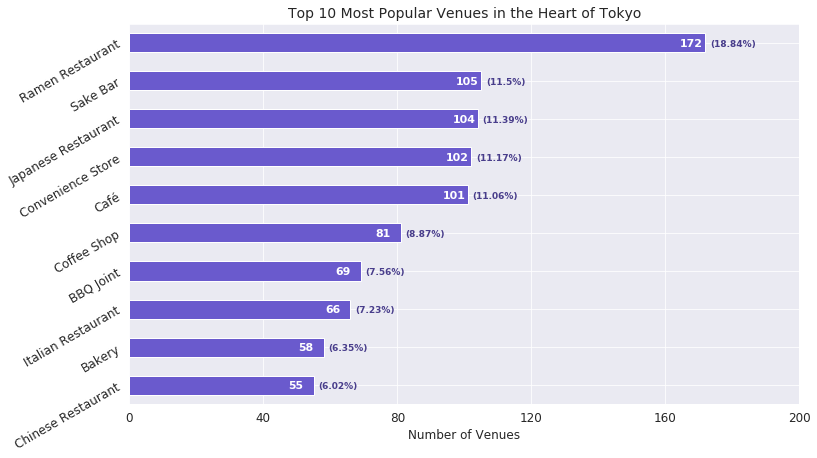

In [26]:
sns.set_style('darkgrid')
cat = top_10['Category']
num = list(range(0,240,40))
ax = top_10['Count'].plot(kind='barh', figsize=(12,7), fontsize=12, color="slateblue");
ax.set_alpha(0.8)
ax.set_title("Top 10 Most Popular Venues in the Heart of Tokyo", fontsize=14)
ax.set_xlabel("Number of Venues", fontsize=12)
ax.set_yticklabels(labels=cat, rotation=30, fontsize=12)
ax.set_xticks(num)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()- 7.5, i.get_y()+.35, \
            str(round((i.get_width()), 2)), fontsize=11, color='w', weight='bold')
    ax.text(i.get_width()+ 1.5, i.get_y()+.35, \
            '('+str(round((i.get_width()/total)*100, 2))+'%'+')', fontsize=9, color='darkslateblue',weight='bold')
# invert for largest on top 
ax.invert_yaxis()

Living up to our expectations, Japanese ramen has won the championship in this competition in the end. Japanese ramen is not only a 'must' for foreign tourists who come to Japan, but also a beloved traditional specialty food from Japanese natives very much. In the result, we can also feel the 'power' of Japanese ramen. The number of ramen bars is around 170, which is nearly 1.5 times that of the second-ranked Cafe (104). From 2nd place to 5th place, the number of gastronomies is basically around 100, no significant difference.  
It is worth noting that the fourth-ranked convenience store is a kind of retail business model with very specific 'East Asian' characteristics. It can be regarded as a reduced-size supermarket that sells all necessities of life, but the range of products available for selection is limited. The existence of convenience stores brings great comfort to people's lives and saves a lot of time.

### Section 4 : Clustering

In [27]:
distortions = []
Tokyo_clustering = tokyo_grouped.drop('Major_districts', 1)
K = range(1,20)
for k in K:
    kmean = KMeans(n_clusters=k, random_state=0, n_init = 500, max_iter = 500)
    kmean.fit(Tokyo_clustering)
    distortions.append(kmean.inertia_)

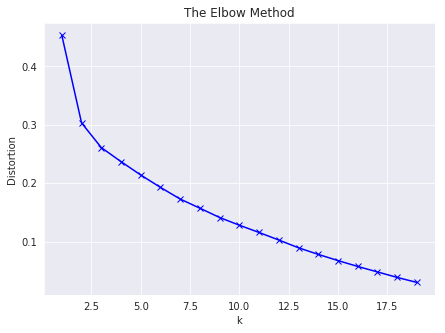

In [28]:
plt.figure(figsize=(7,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

In [29]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Tokyo_clustering)

# check cluster labels generated for each row in the dataframe
print ("Check the Cluster labels :",  kmeans.labels_)

Check the Cluster labels : [3 3 1 2 2 1 1 4 3 2 0 2 2 3 0 0 0 0 3 2 1 0 3]


In [42]:
# add clustering labels
Cluster_merged = data_final.merge(districts_venues_sorted,how='outer')
Cluster_merged.insert(0, 'Label', kmeans.labels_)
Cluster_merged.head()

,Label,Name,Kanji,Major_districts,Population(2020),Area(km²),Density(/km²),MD_Latitude,MD_Longitude,Graduates,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4 th Most Common Venue,5 th Most Common Venue,6 th Most Common Venue,7 th Most Common Venue,8 th Most Common Venue,9 th Most Common Venue,10 th Most Common Venue
0,3,Chiyoda,千代田区,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,...",66080.0,11.66,5667.0,35.693810,139.753216,38922,...,Café,Ramen Restaurant,Japanese Curry Restaurant,Coffee Shop,Soba Restaurant,Hotel,Yoshoku Restaurant,Park,Steakhouse,Garden
1,3,Chūō,中央区,"Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb...",168553.0,10.21,16509.0,35.666255,139.775565,104866,...,Sushi Restaurant,Monjayaki Restaurant,Japanese Restaurant,Ramen Restaurant,Italian Restaurant,Soba Restaurant,Dessert Shop,Bakery,Seafood Restaurant,BBQ Joint
2,1,Minato,港区,"Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong...",260535.0,20.37,12790.0,35.643227,139.740055,170019,...,Japanese Restaurant,Italian Restaurant,BBQ Joint,Sake Bar,Coffee Shop,Pizza Place,Bakery,Ramen Restaurant,Café,Chinese Restaurant
3,2,Shinjuku,新宿区,"Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich...",349101.0,18.22,19160.0,35.693763,139.703632,269217,...,Bar,Sake Bar,Ramen Restaurant,Japanese Restaurant,Coffee Shop,Café,BBQ Joint,Multiplex,Soba Restaurant,Hotel
4,2,Bunkyō,文京区,"Hongō, Yayoi, Hakusan",236043.0,11.29,20907.0,35.718810,139.744732,163476,...,Café,Ramen Restaurant,Italian Restaurant,Japanese Restaurant,BBQ Joint,Chinese Restaurant,Garden,Bakery,Dessert Shop,Park


In [52]:
# create map
map_clusters = folium.Map(location=center, zoom_start=11)
folium.TileLayer('cartodbpositron').add_to(map_clusters)
folium.GeoJson(tokyo_shape, style_function=shape_style, name='geojson').add_to(map_clusters)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(data_final['MD_Latitude'], 
                                  Cluster_merged['MD_Longitude'], 
                                  Cluster_merged['Major_districts'], 
                                  Cluster_merged['Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### Link of map : https://drive.google.com/open?id=1uDTgLVsBwCiDRim4dXoCuIDEW5r0CFUd

In [53]:
Cluster1 = Cluster_merged.loc[Cluster_merged['Label'] == 0, Cluster_merged.columns[[1] + list(range(4, Cluster_merged.shape[1]))]]
Cluster1[['Name','1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
10,Ōta,Ramen Restaurant,Chinese Restaurant,Sake Bar
14,Suginami,Café,Ramen Restaurant,Sake Bar
15,Toshima,Ramen Restaurant,Sake Bar,Café
16,Kita,Ramen Restaurant,Sake Bar,Japanese Restaurant
17,Arakawa,Ramen Restaurant,Japanese Restaurant,Sake Bar
21,Katsushika,Convenience Store,Sake Bar,Discount Store


In [54]:
Cluster2 = Cluster_merged.loc[Cluster_merged['Label'] == 1, Cluster_merged.columns[[1] + list(range(4, Cluster_merged.shape[1]))]]
Cluster2[['Name','1st Most Common Venue','2nd Most Common Venue', '3rd Most Common Venue']]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
2,Minato,Japanese Restaurant,Italian Restaurant,BBQ Joint
5,Taitō,Japanese Restaurant,Coffee Shop,Dessert Shop
6,Sumida,Ramen Restaurant,Japanese Restaurant,Hostel
20,Adachi,Convenience Store,Ramen Restaurant,Discount Store


In [55]:
Cluster3 = Cluster_merged.loc[Cluster_merged['Label'] == 2, Cluster_merged.columns[[1] + list(range(4, Cluster_merged.shape[1]))]]
Cluster3[['Name','1st Most Common Venue','2nd Most Common Venue', '3rd Most Common Venue']]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
3,Shinjuku,Bar,Sake Bar,Ramen Restaurant
4,Bunkyō,Café,Ramen Restaurant,Italian Restaurant
9,Meguro,Bakery,Japanese Restaurant,Coffee Shop
11,Setagaya,Bakery,Coffee Shop,Indian Restaurant
12,Shibuya,Japanese Restaurant,Coffee Shop,Café
19,Nerima,Ramen Restaurant,Italian Restaurant,Convenience Store


In [56]:
Cluster4 = Cluster_merged.loc[Cluster_merged['Label'] == 3, Cluster_merged.columns[[1] + list(range(4, Cluster_merged.shape[1]))]]
Cluster4[['Name','1st Most Common Venue','2nd Most Common Venue', '3rd Most Common Venue']]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Chiyoda,Café,Ramen Restaurant,Japanese Curry Restaurant
1,Chūō,Sushi Restaurant,Monjayaki Restaurant,Japanese Restaurant
8,Shinagawa,Ramen Restaurant,Sake Bar,BBQ Joint
13,Nakano,Ramen Restaurant,Café,BBQ Joint
18,Itabashi,Convenience Store,Ramen Restaurant,Grocery Store
22,Edogawa,Convenience Store,Ramen Restaurant,Indian Restaurant


In [57]:
Cluster5 = Cluster_merged.loc[Cluster_merged['Label'] == 4, Cluster_merged.columns[[1] + list(range(4, Cluster_merged.shape[1]))]]
Cluster5[['Name','1st Most Common Venue','2nd Most Common Venue', '3rd Most Common Venue']]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
7,Kōtō,Convenience Store,Coffee Shop,Park


Judging from the results, it is undeniable that due to the extreme high similarity of the Tokyo special wards, the clustering process using K-means worked not very successful. Nevertheless, it can be roughly divided into 5 clusters according to preference.  

Cluster 1: "Japanese ramen"  
Cluster 2: "Japanese restaurant"  
Cluster 3: "Café", "Bar" or "Bakery"  
Cluster 4-5: relatively messy, mainly including "Convenience Store"  

In addition, some of the ward are not clustered correctly, here are some manual corrections:  

Katsushika: Cluster 1 → Cluster 4  
Suginami: Cluster 1 → Cluster 3  
Sumida: Cluster 2 → Cluster 1  
Adachi: Cluster 2 → Cluster 4  
Shibuya: Cluster 3 → Cluster 2  
Nerima: Cluster 3 → Cluster 1  
Chiyoda: Cluster 4 → Cluster 3  
Chuo: Cluster 4 → Cluster 2  
Shinagawa: Cluster 4 → Cluster 1  
Nakano: Cluster 4 → Cluster 1     
Koto: Cluster 5 → Cluster 4

Now we get updated clusters as below:  

##### Cluster 1: "Japanese ramen"  
Ota, Toshima, Kita, Arakawa, Sumida, Nerima, Shinagawa, Nakano
  
##### Cluster 2: "Japanese restaurant" (inclu. Sushi)  
Minato, Taito, Shibuya, Chuo
 
##### Cluster 3: "Café","Bakery","Bar"  
Suginami, Shinjuku, Bunkyo, Meguro, Setagaya, Chiyoda
 
##### Cluster 4: "Convenience Store"  
Katsushika, Adachi, Itabashi, Edogawa, Koto

### Conclusion

From the previous two battles, Bunkyo District has undoubtedly occupied the throne. At the same time, Chuo, Meguro and Arakawa are also good choices. If want to choose Bunkyo for the business, it is best to avoid Cafes or ramen restaurants. Similarly, no matter which ward to choose, always keeping in mind that avoid the types of shops or restaurants that already exist in large numbers.  However, this project has only done a pretty rough analysis based on tiny databbase about the situation in the Tokyo special wards. In practical, specific problems should be analyzed together with sufficient amount of data for drawing more accurate and appropriate conclusions.